In [18]:
import os
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import random
import nibabel as nib
from pathlib import Path
from pthflops import count_ops
from tqdm import tqdm

print(torch.__version__)

2.0.0


In [19]:
path = "ses-01/anat/sub-HC001_ses-01_acq-inv1_T1map.nii"

In [20]:
img = nib.load(path).get_fdata()
img = np.asarray(img)
img.shape

(240, 320, 320)

In [21]:
#transfrom data
m = np.max(img)
new_img = np.ones((img.shape[2], img.shape[0], img.shape[1], 3))
for i in range(img.shape[2]):
    new_img[i] = np.stack((img[:, :, i], 1*img[:, :, i], 1*img[:, :, i]), axis=2)
new_img *= 1/m


In [22]:
img_curr = new_img[0]

In [23]:
print(img_curr.shape)

(240, 320, 3)


In [24]:
print(img_curr.shape)

(240, 320, 3)


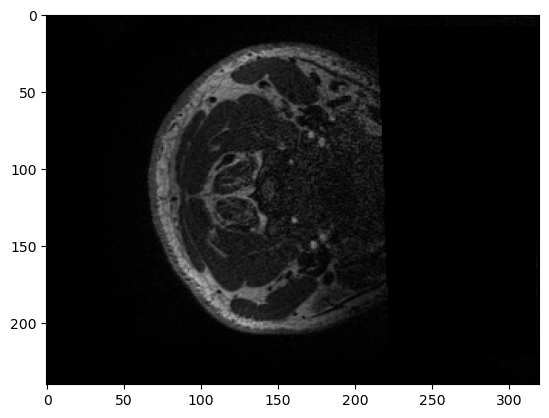

In [25]:
plt.imshow(img_curr)

In [26]:
print("Cuda available: ", torch.cuda.is_available())
if(torch.cuda.is_available()):
    torch.cuda.set_device("cuda:1")

    print("Is cuDNN version:", torch.backends.cudnn.version())

    print("cuDNN enabled:a", torch.backends.cudnn.enabled)

    print("Device count: ", torch.cuda.device_count())

    print("Current device: ", torch.cuda.current_device())

    print("Device name: ", torch.cuda.get_device_name(torch.cuda.current_device()))
#Setup device agnostic code (i.e use GPU if possible)
device = "cuda" if torch.cuda.is_available() else "cpu"
gpuNum = 1
print(device)
img_curr = torch.tensor(img_curr).to(device)

Cuda available:  False
cpu


In [27]:
class hashNerf(nn.Module):
    def __init__(self,
                input_shape: int,
                hidden_units: int,
                output_shape: int,
                L=16, T=2**18, F=2, N_min=8, N_max=256, num_output=3):
        self.L = L
        self.T = T
        self.F = F
        self.N_min = N_min
        self.N_max = N_max
        self.num_output = num_output
        super().__init__()
        b = np.exp((np.log(self.N_max) - np.log(self.N_min)) / (self.L - 1)) # scalar 
        self.N_values = torch.floor(torch.tensor(np.float32(self.N_min * b ** np.arange(self.L)))).type(torch.int64).to(device) # dim : 16,1
        print("n_values:", self.N_values)
        temp_hash_table = torch.FloatTensor(L,T,F).uniform_(-1e-4, 1e-4) # dim : L, T, F
        self.hash_table = nn.Parameter(torch.tensor(temp_hash_table.clone(), requires_grad=True).to(device).type(torch.float32))
        self.vertices = torch.transpose(torch.tensor([
                        [0,0],
                        [0,1],
                        [1,0],
                        [1,1]]), 0,1).type(torch.float32).to(device) # dim : (2,4)
        self.prime_numbers = torch.tensor([1, 2654435761]).type(torch.int64).to(device)

        self.layer_stack = nn.Sequential(
            nn.Linear(input_shape, hidden_units),
            nn.LeakyReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.LeakyReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.LeakyReLU(),
            nn.Linear(hidden_units, output_shape),
            nn.ReLU()
        ).to(device)
    
    def forward(self, X):
        # X : 2D coordinates -> (num_points, 2)
        #print(self.hash_table)
        X = X.to(device)
        x_shape = X.shape
        x_scaled = X[:, :, None] * self.N_values[None, None, :]
        x_floor = torch.floor(x_scaled) # dim : (batch_size, 2, L)
        x_ceil = torch.ceil(x_scaled) # dim : (batch_size, 2, L)
        x_vertices = torch.zeros((len(x_floor), 2, self.L, 4)).to(device) # dim : (batch_size, 2, L, 4)
        x_vertices = x_floor[:, :, :, None] * self.vertices[None, :, None, :]
        x_vertices = x_vertices.type(torch.int64)
        
        primesTemp = torch.tensor([1, 2654435761]).type(torch.int64).to(device)
        x_to_hash_temp = x_vertices * primesTemp[None, :, None, None]

        x_hash_temp = torch.bitwise_xor(x_to_hash_temp[:, 0],
                                        x_to_hash_temp[:, 1]) # shape: num_points, L, 4
        x_hash_temp = torch.remainder(x_hash_temp, self.T) 
        x_hash = x_hash_temp
        x_hash = x_hash.to(device)
        #Tricky code
        x_hash = x_hash.permute(1, 0, 2)  # shape: L, num_points, 4

        lookup = torch.stack([self.hash_table[i][x_hash[i]] for i in range(self.L)], dim=0).to(device)
        #print('lookup shape:',lookup.shape)
        lookup = lookup.permute(1,0,2,3)  # shape: num_points, L, 4, F
        #print(lookup.shape)
        
        #interpolation
        weights = x_scaled - x_floor
        #print("weights:", weights)
        fx = weights[:, 0, :]
        cx = 1 - fx
        fy = weights[:, 1, :]
        cy = 1 - fy

        f11 = fx * fy
        f10 = fx * cy
        f01 = cx * fy
        f00 = cx * cy

        f_stack = torch.stack([f00, f01, f10, f11], dim=2).to(device)  # shape: num_points, L, 4
        #print(f_stack.shape)
        x_interp = torch.sum(f_stack[:, :, :, None] * lookup, dim=2)  # shape: num_points, L, F
        #print('x_interp shape:', x_interp.shape)
        x = x_interp.reshape(-1, self.L * self.F) # dim : num_points, L*F
        return self.layer_stack(x.to(device).type(torch.float32))

In [28]:
## Utils
import math
def PSNR(MSELoss, max):
    return (20*math.log10(max)) - (10*math.log10(MSELoss))

In [29]:
img_curr[0][1]

tensor([0.0029, 0.0029, 0.0029], dtype=torch.float64)

In [30]:
import os
from torch.utils.data import DataLoader
class SingleImageDataset(Dataset):
    def __init__(self, image, transform=None, target_transform=None):
        self.image = image.type(torch.float32)
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return int(self.image.shape[0]) * int(self.image.shape[1])
    def __getitem__(self, idx):
        row = idx // int(self.image.shape[1])
        col = idx % int(self.image.shape[1])
        pixel = torch.as_tensor(self.image[row][col]).type(torch.float32).to(device)
        #label = pixel 
        row = row / (self.image.shape[0])
        col = col / (self.image.shape[1])
        return torch.as_tensor([row, col]).type(torch.float32).to(device), pixel

In [31]:
#initialize model
model_0 = hashNerf(32, 128, 3)

n_values: tensor([  8,  10,  12,  16,  20,  25,  32,  40,  50,  64,  80, 101, 128, 161,
        203, 256])


/var/folders/47/kdzqfc9j7csfgrbl6qstjc780000gn/T/ipykernel_63690/3387448863.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.hash_table = nn.Parameter(torch.tensor(temp_hash_table.clone(), requires_grad=True).to(device).type(torch.float32))


In [32]:
lr1 = 0.01
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=lr1, eps=10e-15)

In [35]:
training_data = SingleImageDataset(img_curr)
train_loader = DataLoader(training_data, batch_size=2**14, shuffle=True)

In [36]:
# Training
from tqdm import tqdm
PSNR_thresh = 37
batchCount = 0
psnr_table = []
savedAt25 = False
savedAt30 = False
exit_loop = False
for epoch in tqdm(range(0,50)):
    model_0.train()
    for batch in iter(train_loader):
        batchCount += 1
        y_train = torch.as_tensor(batch[1]).to(device)
        #print(y_train.shape)
        y_train = torch.squeeze(y_train)
        #print(y_train.shape)
        X = torch.as_tensor(batch[0]).type(torch.float32)
        y_train = torch.as_tensor(y_train).type(torch.float32)
        # Forward Pass
        y_pred = model_0(X).to(device).type(torch.float32)
        #print(y_pred.shape)
        loss = loss_fn(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    psnr = PSNR(loss, 1.0)
    psnr_table.append(psnr)
    if (psnr >= PSNR_thresh):
        break
    if epoch % 1 == 0:
        print(f"Epoch: {epoch} | LR: {lr1} | Train loss: {loss} | PSNR: {psnr}")
    """
    if epoch == 10:
        lr1 = lr1/10
    if epoch == 20:
        lr1 = lr1/2
    """
print('Training Finished')

  2%|▏         | 1/50 [00:01<01:23,  1.71s/it]

Epoch: 0 | LR: 0.01 | Train loss: 0.004332226235419512 | PSNR: 23.63288871938498


  4%|▍         | 2/50 [00:03<01:19,  1.66s/it]

Epoch: 1 | LR: 0.01 | Train loss: 0.004338661674410105 | PSNR: 23.626442145090664


  6%|▌         | 3/50 [00:04<01:17,  1.65s/it]

Epoch: 2 | LR: 0.01 | Train loss: 0.004328813403844833 | PSNR: 23.63631134313223


  8%|▊         | 4/50 [00:06<01:15,  1.64s/it]

Epoch: 3 | LR: 0.01 | Train loss: 0.004182805307209492 | PSNR: 23.78532349613101


 10%|█         | 5/50 [00:08<01:13,  1.62s/it]

Epoch: 4 | LR: 0.01 | Train loss: 0.0044908300042152405 | PSNR: 23.47673384400344


 12%|█▏        | 6/50 [00:09<01:10,  1.60s/it]

Epoch: 5 | LR: 0.01 | Train loss: 0.00463732797652483 | PSNR: 23.337321873999024


 14%|█▍        | 7/50 [00:11<01:08,  1.59s/it]

Epoch: 6 | LR: 0.01 | Train loss: 0.004401861224323511 | PSNR: 23.56363653391157


 16%|█▌        | 8/50 [00:12<01:06,  1.59s/it]

Epoch: 7 | LR: 0.01 | Train loss: 0.0044026789255440235 | PSNR: 23.562829852079496


 18%|█▊        | 9/50 [00:14<01:04,  1.58s/it]

Epoch: 8 | LR: 0.01 | Train loss: 0.004304041620343924 | PSNR: 23.6612353766734


 20%|██        | 10/50 [00:16<01:02,  1.57s/it]

Epoch: 9 | LR: 0.01 | Train loss: 0.004474860616028309 | PSNR: 23.492204876402525


 22%|██▏       | 11/50 [00:17<01:01,  1.57s/it]

Epoch: 10 | LR: 0.01 | Train loss: 0.004483161494135857 | PSNR: 23.484156165326432


 24%|██▍       | 12/50 [00:19<00:59,  1.57s/it]

Epoch: 11 | LR: 0.01 | Train loss: 0.0045418813824653625 | PSNR: 23.42764212171201


 26%|██▌       | 13/50 [00:20<00:58,  1.57s/it]

Epoch: 12 | LR: 0.01 | Train loss: 0.004273361526429653 | PSNR: 23.692303643108644


 28%|██▊       | 14/50 [00:22<00:56,  1.58s/it]

Epoch: 13 | LR: 0.01 | Train loss: 0.004389962647110224 | PSNR: 23.575391750250603


 30%|███       | 15/50 [00:23<00:54,  1.57s/it]

Epoch: 14 | LR: 0.01 | Train loss: 0.004672471433877945 | PSNR: 23.304533450902973


 32%|███▏      | 16/50 [00:25<00:53,  1.57s/it]

Epoch: 15 | LR: 0.01 | Train loss: 0.004301672335714102 | PSNR: 23.66362673495475


 34%|███▍      | 17/50 [00:26<00:51,  1.57s/it]

Epoch: 16 | LR: 0.01 | Train loss: 0.004210211336612701 | PSNR: 23.756961036842558


 36%|███▌      | 18/50 [00:28<00:50,  1.56s/it]

Epoch: 17 | LR: 0.01 | Train loss: 0.004421141929924488 | PSNR: 23.54465542910543


 38%|███▊      | 19/50 [00:30<00:49,  1.60s/it]

Epoch: 18 | LR: 0.01 | Train loss: 0.004450017586350441 | PSNR: 23.516382726955037


 40%|████      | 20/50 [00:31<00:48,  1.63s/it]

Epoch: 19 | LR: 0.01 | Train loss: 0.004255230538547039 | PSNR: 23.710769058716103


 42%|████▏     | 21/50 [00:33<00:46,  1.62s/it]

Epoch: 20 | LR: 0.01 | Train loss: 0.00429306598380208 | PSNR: 23.672324364260085


 44%|████▍     | 22/50 [00:35<00:45,  1.61s/it]

Epoch: 21 | LR: 0.01 | Train loss: 0.004394371993839741 | PSNR: 23.571031818183968


 46%|████▌     | 23/50 [00:36<00:43,  1.62s/it]

Epoch: 22 | LR: 0.01 | Train loss: 0.004571215715259314 | PSNR: 23.399682839094705


 46%|████▌     | 23/50 [00:37<00:44,  1.65s/it]


KeyboardInterrupt: 

In [154]:
model_0.eval()
x_test_T = torch.as_tensor(img_curr)
z = 1
reconstruction_input_matrix = torch.zeros(img_curr.shape[0], img_curr.shape[1], 2).type(torch.float32)
#encode coordinates into debug matrix
for i in range(0, x_test_T.shape[0]):
    for j in range(0, x_test_T.shape[1]):
        reconstruction_input_matrix[i][j] = torch.as_tensor([i/(img_curr.shape[0]),j/(img_curr.shape[1])]).type(torch.float32)
reconstruction_input_matrix = torch.flatten(reconstruction_input_matrix, 0, 1)



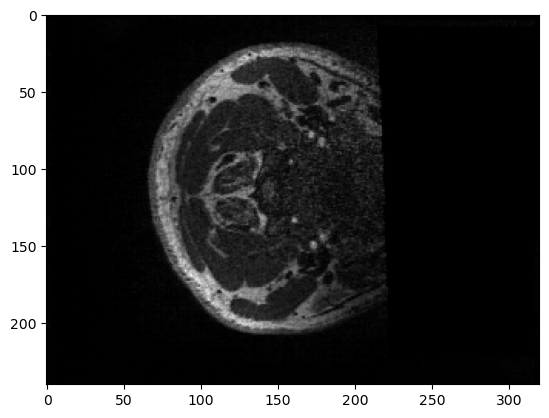

In [156]:
im_psnr_note = 37
model_0.eval()
with torch.inference_mode():
    reconstruction = model_0(reconstruction_input_matrix).cpu()
    reconstruction = reconstruction.reshape((img_curr.shape[0], img_curr.shape[1],3))
    plt.imshow(reconstruction[:, :, 0], cmap="gray")
    plt.axis(True)
    #plt.title("HashNerf - PSNR:"+ str(round(psnr_table[-1], 4)))
    #plt.savefig("c_elegans_reconstructions/hash_nerf_reconstruction_frame_"+str()+"_psnr_"+str(im_psnr_note)+".png", bbox_inches="tight", pad_inches=0.0)
    #save
    